
<h1 align="center">Happiness analysis in Danish Stack Overflow community</h1> 
<h2 align="center">Assignment B</h2> 
<h5 align="center">Handin 7/12-2016</h5> 


In [1]:
#first the libraries used in the code
#download and process the data
import urllib2, requests, json
import csv,io
import re
from TwitterSearch import *
from bs4 import BeautifulSoup

#text analysis
import nltk
import csv, requests, json
import re
import io
import pickle
import numpy as np
import os
from guess_language import guessLanguage
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
import math
import matplotlib.cm as cm

#network analysis
import networkx as nx
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout
import pickle
import community

#others
from collections import defaultdict
from itertools import count
from itertools import islice
import operator

<h2 align="center">Motivation</h2> 



What makes people happy? or more specifically what makes a programmer happy? And how do you become a happy programmer? 
These questions were the starting point for this project, where we wanted to put the users of Stack Overflow (SO), the largest online community for programmers [1],  under a magnifying glass and discover happiness factors for  this community. 

When doing a project about happiness, we need to first define exactly what that is. Definitions are many, but the following  description made by psychology researcher Sonja Lyubomirsky was found quite accurate: *"the experience of joy, contentment, or positive well-being, combined with a sense that one’s life is good, meaningful, and worthwhile."*
[2] 

The project started with stating some initial hypotheses we wanted to explore and either confirm or reject in the end. The hypotheses were based on different articles about happiness [3][4]: 
1. People that code in clojure, Scala, Ruby or JavaScript are the most happy [5]
2. Caring about others and helping makes people happy (in SO it could be the people who answer most)
3. Being acknowledged, doing something meaningful (Like winning batches and reputation in SO) makes people happy
4. Money makes people happy


The dataset used is composed from both SO and Twitter data. It might seems obvious to analyse the text on SO, such as question and answers, however due to the writing style on a Q&A site, the sentiment from there would most likely not give a clear indication of the sentiment of a person. More on this under Sentiment. Stack Overflow’s API and the Stack Exchange Data Explorer [7] were used to get all the users in Denmark and their answers, tags, tweet usernames etc. The tweets were then retrieved from Twitter, using Twitter's API.  In all, the data consists of danish SO users data and their twitter history. This made it possible to get simple statistics on the user, create networks based on tags, users etc. and do sentiment analysis on the tweets. Overall the project aims at understanding the danish SO users, find out what makes them happy and the parameters that defines happiness within this community. All of this is also available on a [website](https://alinasgzan.github.io/social_graphs/) which converts the analysis results into nice, digestible information anyone can understand, so everyone can find out what to do to become a happy(er) programmer. 


***

<h2 align="center">Basic stats</h2> 

Knowing and understanding the data is the place to start; to begin with, some preprocessing was required, to clean and define the specific data even more. As mentioned, only the danish part of the SO community was chosen - in order to minimize the scope of the problem. Besides, the project is about happiness and Denmark is known to be the happiest nation in the world.

#### Stack Overflow
Stack Overflow is an online community of professional and enthusiast programmers where you can ask and answer questions (related to programming and technologies). SO is a part of Stack Exchange, which is a network of more than 150 Q&A online communities; SO is one of its main sites and has 6.4 mill. users as of December 2016 [6]. All the sites under Stack Exchange include, beside the Q&A, some functionalities: 
1. Upvoting and downvoting answers, to ensure the best answer is on top
2. Users earn badges based on several parameters: helpful answers, question asked, question within the same field, etc. 
3. To indicate what type of question or answer, tags are added to represent either a programming language or a technology. 


**Users**


To get an initial list of users, the [Stack Exchange Data Explorer][7] *("an open source tool for running arbitrary queries against public data from the Stack Exchange network*), was used. 


Here is the sql snippet used:


>`SELECT Id [User Link], Reputation, DisplayName, Location
>FROM Users
>WHERE Location like '%##Location##%'
>ORDER by Reputation desc`



This resulted in a list of 5717 users (as of 9th of November 2016). Note that more users have registered since, so the query might return more rows now). A shortcoming of the above method is that it will only retrieve users that have listed "Denmark" as their location. There are a number of danish users who only list their city, for instance (http://stackoverflow.com/users/1956457/baumi - Odense or http://stackoverflow.com/users/3986879/ulf-aslak / http://stackoverflow.com/users/2399772/demitrian - Copenhagen), list their location as "Danmark", or do not list their location at all. However, it is out of the scope to search for all the SO users really living in Denmark.

As a side note, Stack Exchange Data Explorer database is updated every Sunday [8].


In [3]:
user_ids = []
with open('QueryResults.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        user_id = row['User Link'], row['DisplayName']
        user_ids.append(user_id)     

#get a list of the user ids only:
users=[user[0] for user in user_ids]

print len(users)

5717


More user data can be retrieved using the Stack exchange Developer. This is useful for basic stats and for generating the networks. An overall query is shown below. 
>`SELECT Id AS [Id Link], DisplayName, Reputation, WebsiteUrl, Location, AboutMe, Views, UpVotes, DownVot, Age, AccountId
>FROM Users
>WHERE LOWER(Location) LIKE '%denmark%'
>ORDER BY Reputation DESC`


However the most relevant elements for this project were extracted using the queries below .
For selecting total number of answers, total number of accepted answers and reputation:

>`SELECT answer.OwnerUserId As [User Link],'http://stackoverflow.com/users/' + Cast(answer.OwnerUserId as nvarchar(10)) 
>As [Permalink], Users.Reputation, count(answer.id) AS [Total Answers], count(question.id) AS [Accepted Answers]
>FROM Posts answer LEFT OUTER JOIN Posts question ON question.AcceptedAnswerId = answer.id INNER JOIN Users ON >answer.OwnerUserId = Users.id
>WHERE answer.postTypeId = 2 -- 2 means that post is an answer AND Users.Location like '%denmark%'
>GROUP BY  answer.OwnerUserId,  Users.Reputation
>ORDER BY Users.Reputation desc`

And for selecting the total number of questions asked (for users who have at least asked one question):

>`SELECT
>  answer.OwnerUserId As [User Link],
>  count(answer.id) AS [Total Questions]
>FROM
>  Posts answer
>  LEFT OUTER JOIN Posts question ON question.AcceptedAnswerId = answer.id
>  INNER JOIN Users ON answer.OwnerUserId = Users.id
>WHERE
>  answer.postTypeId = 1 -- 1 means that post is a question
>  AND 
>  Users.Location like '%denmark%'
>GROUP BY 
>  answer.OwnerUserId`

SO has a total number of 47060 unique tags [9]. A user earns a tag anytime he asks or answers a question having that tag. At a glance, the danish SO users community has in total 148723 tags, a number of 16395 unique tags (roughly one third of the unique SO tags), 95140 total answers, 35464 accepted answers and 35824 questions. 

In [3]:
reader = csv.reader(open("users_answers.csv","rb"))
reader.next()
print 'Total answers : '+ str(sum(int(x[3]) for x in reader))
#print 'Total accepted answers : '+ str(sum(int(x[4]) for x in reader))

reader2 = csv.reader(open("questions.csv","rb"))
reader2.next()
print 'Total questions: '+ str(sum(int(x[1]) for x in reader2))


Total answers : 95140
Total questions: 35824


In [4]:
#list holding all the tags, from all users
all_tags=[]

#list holding the tag count for all users
all_tags_counts=[]

for user in users:
    with open('tags/'+user+'.csv', 'rt') as tags_csv:
        tag_reader = csv.reader(tags_csv)     
        tags=[tag[0] for tag in tag_reader]
        
        #add the tags to the list of all tags
        all_tags.extend(tags)
        
        #append the tags count to the list with tags counts
        all_tags_counts.append(len(tags))
        
print "Tags in total: " + str(len(all_tags))
print "Unique number of tags " + str(len(set(all_tags)))

Tags in total: 148723
Unique number of tags 16395


The tags were downloaded by calling the SO API and saved to individual text files. Here is the code snippet used to download all the tags for all users.

In [ ]:
#API call to get all the tags for all users:
#the parameters
params = dict(
    site='stackoverflow',
    pagesize = '100',
    
    #replace with a valid Stack app key:
    key='#####'
)

for user in users:
    i=0
    data['has_more']= True
    
    #open the file username.csv for each user 
    with io.open('tags/'+user+'.csv', 'wb') as out_file:
        writer = csv.writer(out_file)
        while (data['has_more']):
            i=i+1
            resp = requests.get(url='https://api.stackexchange.com/2.2/users/'+user+'/tags?&page='+str(i), params=params)
            data = json.loads(resp.text) 

            for item in data['items']:
                #write the tags to the file
                writer.writerow( (item['name'],item['count']) )
            
            #check the backoff flag of the API (see http://api.stackexchange.com/docs/throttle):
            if 'backoff' in data:
                time.sleep(data['backoff'])

The danish SO users have tags ranging between 0 (no tags) and 1930 tags. 
In the plot bellow, showing a distribution of the number of tags, we can see that most users have up to 200 tags; the distribution is higly skewed to the left.

In [5]:
max(all_tags_counts)

1930

In [6]:
#defining the histograms..
#..automatically
hist = np.histogram(all_tags_counts, bins=range(1,max(all_tags_counts)+1))

#..or with a given number of bins
#hist = np.histogram(all_tags_counts, bins=100)

x = hist[1]
y = hist[0]

trace0 = go.Bar(
    x = x,
    y = y,
    marker=dict(
        color='rgb(49,130,189)'
    )
)

data = [trace0]
layout =go.Layout(
    xaxis = dict(
        tickangle=0,
        title = "Number of tags"
    ),
    yaxis = dict(
        title = "Number of users"
    ),
    barmode = 'group',
    title = "Number of tags distribution ",
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Number of tags distribution')

By looking at the actual tags, we can see which ones are most popular with the the SO users.

In [7]:
#function to return the top 25 items, by count
def get_top(xs, top=25):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:top]

In [9]:
get_top(all_tags)[:10]

[('javascript', 1596),
 ('c#', 1423),
 ('html', 1246),
 ('php', 1184),
 ('jquery', 1157),
 ('java', 1019),
 ('css', 982),
 ('mysql', 846),
 ('sql', 795),
 ('asp.net', 746)]

#### Twitter
The Data Explorer offers only a limited number of user information attributes: due to privacy considerations user email and twitter account are not included. In order to get the twitter account for each user we have used the BeautifulSoup library to scan all HTML pages corresponding to the user profiles of the users in the above list. 

The tweets are used to generate a sentiment analysis for each of the user as the backbone of the happiness indication and to compare it with the rest of the statistics and the measurements of the generated network. 

In [7]:
#check all the user profiles for a twitter account
for element in user_ids:
    url = 'http://stackoverflow.com/users/' +  str(element[0])
    data = urllib2.urlopen(url)
    soup = BeautifulSoup(data, 'lxml')

    f=open('twitterfile.csv', 'a')
    writer = csv.writer(f)
    
    for a in soup.find_all('a', href=True):
        #look for any href tag containing twitter.com in it
        if 'twitter.com/' in a['href']:
            #open a file to write all the link matches
            with open('twitterfile.csv', 'a') as f:
                try:
                    #Write the usernames and twitter link as a row 
                    writer.writerow( (element[1], a['href']) )
                finally:
                    f.close()

Not all SO users have a Twitter account associated. Moreover, Twitter is not so popular in Denmark as in other places of the world. From the above list we extracted 602 twitterlinks, corresponding to 586 unique users (some users have included their twiter account twice or more). We saved the twitter links in a csv file.

In [5]:
#get a list of the twitter links
import pandas
twitter_users = pandas.read_csv('twitterfile.csv')
twitter_links = twitter_users.link.tolist()

#strip the links to only get username (everything after the last backslash)
pretty_links = [link.rsplit('/', 1)[-1] for link in twitter_links]

#since there are duplicates (some stackoverflow users include their twitter acount twice)
# we need a unique list of tweeter usernames:
uniqueids = set(pretty_links)

#the final twitter username list
unique_twitter_user_ids = list(uniqueids)#get a list of the twitter usernames 

print len(twitter_links)
print len(unique_twitter_user_ids)

602
586



We used the following getTweets() function to get the timelines (all the tweets a user has made) of the 586 users found above. This function makes use of the TwitterSearch library to interact with the Twitter API. The individual tweets were saved locally in text files. Please note that in order to be able to run the code, the Twitter API credentials must be provided in the code.    

In [35]:
#function to get the tweets in individual files
def getTweets(usernames_list):
    for user in usernames_list:
        try:
            twitter_user = TwitterUserOrder(user) 

            #create TwitterSearch object - replace with actual credentials here:
            ts = TwitterSearch(
                consumer_key = '#####',
                consumer_secret = '####',
                access_token = '####',
                access_token_secret = '####'
            )  
            
            #open a file with the username.txt name
            with io.open('tweets/'+user +'.txt','w', encoding ='utf-8' ) as out_file:
                for tweet in ts.search_tweets_iterable(twitter_user):
                    out_file.write(tweet['text'])
        
        # catch any errors
        except TwitterSearchException as e: 
            print(e)

In [ ]:
#calling the function to get the tweets:
getTweets(unique_twitter_user_ids)

To give you a small example of the TwitterSearch library, we print some tweets of a test user:

In [11]:
try:
    test = TwitterUserOrder('ploeh') 
    tweet_list=[]
    
    #create TwitterSearch object
    #if you want to run this code, please replace the key and token fields with valid credentials 
    ts = TwitterSearch(
                consumer_key = '####',
                consumer_secret  = '####',
                access_token = '####',
                access_token_secret  = '####'
            )

    #query for the timeline
    for tweet in ts.search_tweets_iterable(test):
        tweet_list.append( '@%s tweeted: %s' % ( tweet['user']['screen_name'], tweet['text']))

except TwitterSearchException as e: # catch any errors
    print(e)

for tweet in tweet_list[:3]:
    print tweet

@ploeh tweeted: In a response to a reader question (scroll down), I almost wrote another blog post about how easy it is to model do… https://t.co/n9oWRHBUeX

@ploeh tweeted: @anderssamuelsen Betyder det at vi endelig vil begynde at bruge så mange penge på forsvaret, som vi allerede har lovet NATO at vi vil gøre?

@ploeh tweeted: @Laumania That Kaj magnet has been on the fridge for more than 10 years. It's a good fridge magnet! :D

@ploeh tweeted: RT @JerryWeinberg: Code should run as fast as necessary, but no faster; something important is always traded away to increase speed—Richard…

@ploeh tweeted: @Danielovich FTR, I haven't used it in production. My current client logs using the ELK stack, and that works well from .NET as well...

@ploeh tweeted: @Danielovich Have you looked into SeriLog from @nblumhardt ?

@ploeh tweeted: @drboolean Related: https://t.co/BRMYn6R0OK

@ploeh tweeted: @dalager Du har tydeligvis aldrig set Wim Wenders' Until the End of the World ;)

@ploeh tweeted: @

What is important to notice here is that besides users not having a twitter count associated,some users who do have one did not necessarily tweet that often. This and more details about the tweets will be discussed further in the sentiment subsection of of the next section.

***

<h2 align="center">Tools, theory and analysis </h2> 


### Sentiment Analysis

This sentiment was the backbone of the project, since it was used as a comparitative method for the network analysis. To create the analysis, several elements had to be considered, such as how to analyse the text, what text to analyse, language and how to score the sentiment. All of which will be described and shown below. 

#### Tweets
First things first, to work on and analyze the tweets, they needed to be fixed. The text files consists of tweets for each new line, which needed to be cleaned, so that they only consists of words. This was done using regular expressions, or in other terms the regex puthon library [9]. This is very useful when finding, sorting or searching elements in a text. The regex searches, or matches specific patterns, and for the tweets it was used to remove unwanted elements and symbols that would not be relevant to the sentiment analysis, such as  weblinks, hashtags and other irrelevant symbols. The tweets were also divided based on the keyword 'newtweet' added before a new tweet. A fuction was created that cleaned the tweets, seperated them and added the to a list. Note that for this project retweet or tweet was not seperated, all counted as the users tweet. 


In [27]:
#Getting a list of tweets for a user
def get_tweets(username):
    list_of_tweets = []
    #open the file
    with io.open('new_tweets/' + username , "r", encoding = 'utf-8') as infile:
        #generate it as one long string to avoid unwanted cutoffs based on \n
        data=infile.read().replace('\n', '')
        #split the string based on the keyword
        test = data.split("newtweet")
        #clean the tweet and add it to the list
        for i in test:
            tweets_cleaned_hashtags = re.sub(r'#', ' ',i)
            tweets = re.sub(r"http\S+", "",tweets_cleaned_hashtags)
            list_of_tweets.append(tweets)
        return list_of_tweets

In [12]:
#to show the output of the function, a small example is shown.
print len(get_tweets('lars_ole.txt'))
test_tweet = get_tweets('lars_ole.txt')
for i in range(1,7):
    print 'tweet nr: ', i, test_tweet[i]

        

3236
tweet nr:  1 @SandraLee_48 watch the video and realise the big mistake not standing behind Clinton
tweet nr:  2 @SandraLee_48 So you are happy now? 
tweet nr:  3 @gatopeich @NaomiAKlein @democracynow So enjoy. Thanks for helping fucking us all up 
tweet nr:  4 @BernBrigade @NaomiAKlein @democracynow yeah you have gotten the world burned 
tweet nr:  5 @KevinMagnussen We are looking forward to see you in a Haas car next year!
tweet nr:  6 RT @skov_frank: Det er sgu svært ikke at være glad for hvor dygtige danske udviklere er på vindområdet. Vind og vand energi til  dkpol og @…


#### Language
Given the fact that we are talking about Danish Twitter users, an important preprocessing part for the text analysis was to distinguish between the languages of tweets. Unfortunately it was not possible to simply assume that everyone tweets in danish,  especially since Denmark is quite diverse in types of nationalities and languages. From a preliminary look at the tweets, it was clear that the tweets were in many languages but mostly dansh or english. Many approaches were tried, to fix this issue. A quick research on the web pointed towards using a stopwords approach - this consists in comparing the text against a list of stopwords and based on the stopwords frequency match, guess the language. However this proved unefficient, due to the fact that the languages share a number of stopwords (i, for, at) and due to the short lenght nature of tweets and because it is guessing norweigan instead of danish when testing it on small examples.  

We have instead tested a number of pyhton libraries and ended up using [the guess language libray](https://bitbucket.org/spirit/guess_language ). [10], because this was the most accurate. The downside of this library is that even if pyEnchant was installed it still did not recognize small sentences. However the libraries found that did work with small text examples were non-deterministic, meaning that it does not necessarily choose the same language everytime it is run. 

In [29]:

#Test of guessLanguage
t = 'Are you coming too?'
t_long = 'Are you coming too? yes!'
l = 'Det er sjov ting du!'
l_long = 'Det er sjov ting du siger!'
print 'guessing short sentences: ',t,  guessLanguage(t), l,guessLanguage(l)
print 'guessing long sentences',t_long, guessLanguage(t_long),l_long, guessLanguage(l_long)
    
guess_text_da = "Checker stadig twitter hver dag :) Poster ikk rigtigt herinde, lser bare. so stfu "
guess_text_en = "OMG i just saw the funniest thing, tweet ha ha! lol"
print 'The first tweet is guessed as: ', guessLanguage(guess_text_en), ' The next tweet is guessed as: ', guessLanguage(guess_text_da)

guessing short sentences:  Are you coming too? UNKNOWN Det er sjov ting du! UNKNOWN
guessing long sentences Are you coming too? yes! en Det er sjov ting du siger! da
The first tweet is guessed as:  en  The next tweet is guessed as:  da


Now that the languages are handled by the library, next step is to decide how to distinguish the languages. To simplify the process, it was decided to only look at sentiment of tweets guessed as either english or danish and ignore the rest of languages that migh be. Otherwise a sentiment score had to be done for each language. But do people who tweet in danish, only tweet in danish? From the code below it is quite clear that even if some tweets are in dansih, it does not mean that they all are. 

In [21]:
#to show the output of the function, a small example is shown.
test_tweet = get_tweets('lars_ole.txt')
for i in range(1,7):
    print 'language of tweet nr: ', i, ' = ',guessLanguage(test_tweet[i])

language of tweet nr:  1  =  en
language of tweet nr:  2  =  en
language of tweet nr:  3  =  en
language of tweet nr:  4  =  en
language of tweet nr:  5  =  en
language of tweet nr:  6  =  da


This means that the tweets needs to be divided  and the language guessed for each tweet, in order to actually ensure that the language guessing comes into play. 

### Sentiment

Two sentiment methods were needed, one for danish and one for english. To create a sentiment score method for a language, a lexicon or a word list consisting of common words for that language were needed. For the English tweets the Mechanical Turk (s1) sentiment list was used [11], for the Danish tweets the AFINN word list was used [12].

Eventhough the AFINN comes with a library that calculates the score, both the s1 and the AFINN is caculated by the same method, this was to ensure that they were calculated in the same way and that the text was handled in the same way in terms of tokenization and unicode. Besides when using the AFINN score it goes both above and below the -5 and 5.. 

To get the sentiment score, the wordlist needed to be converted into dictionaries that could later be called. The function to this were created as generic as possible, which meant that it contains parameters that define the columns, removes unwanted headers etc.  

Note that to handle encoding of the wordlist and especially when working with danish words that contains æ,ø,å, the words from the word list were encoded as unicode, and so is the tweet method further down. 

In [4]:
#function to define if element is a float - this is needed in the next function
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False


In [5]:
#Function for getting the sentiment file, the parameters sets the range, the columns and the file to use. This works for both !!
def sentiment(type_sentiment, column_1, column_2, range_):
    dict_s = {}
    #ensuring cooperation with dansih and tweets the files are encoded. 
    with io.open(type_sentiment, 'r',encoding='utf-8' ) as f:
        #Ensuring that the range can be used as a parameter by splitting the string input
        range_= map(int, range_.split(":"))
        read_words = f.readlines()[range_[0]:range_[1]]
        #creating the dictionary.
        for i in read_words:
            if isfloat(i.split()[column_2]) == False:
                key = i.split()[column_1] + ' '+ i.split()[column_2]
                value = i.split()[2]
            else:
                key =i.split()[column_1]
                value = float(i.split()[column_2])
            dict_s[key] = value
        return dict_s
          

In [53]:
#printing a test for S1 and defining it:
s1_sentiment = sentiment('Data_Set_S1.txt', 0,2, "4:-1")
#printing a test of a word and its value
for k,v in s1_sentiment.items():
    if k == 'sad':
        print k,v
s1_dict =s1_sentiment.keys()[2], s1_sentiment.values()[2]
print 'Words in Mechanical Turk aka s1: ', len(s1_sentiment)

sad 2.38
Words in Mechanical Turk aka s1:  10221


In [7]:
#printin a test for AFINN dk and defining it:
dk_sentiment = sentiment('danish_AFINN.txt', 0,1, "0:-1")
#printing a test of a word and its value
dk_dict =dk_sentiment.keys()[1], dk_sentiment.values()[1]
print dk_dict
print 'Words in AFINN Danish: ', len(dk_sentiment)

 (u'lortehoved', -4.0)
Words in AFINN Danish:  3550


There is a english version of the AFINN, but since it only consist of 3381 words, the s1 with its 10221 words seemed the most accurate.

In [51]:
#printin a test for AFINN uk and defining it:
UK_sentiment = sentiment('english_AFINN.txt', 0,1, "0:-1")
#printing a test of a word and its value
for k,v in UK_sentiment.items():
    if k == 'sad':
        print k,v

print 'Words in AFINN english: ', len(UK_sentiment)

sad -2.0
Words in AFINN english:  3381


The AFINN scores words between -5 and 5, and the s1 scores words between 1.3 and 8.5,  So to ensure that the two languages could be calculated together a convertion function was created. The convertion is based on the AFINN scoring. It is done by assesing the distance between the AFINN score and then based on the index it will give the correct AFINN score.

In [59]:
import numpy as np

#method for converting s1 score to AFINN score
def convert_score(s1_score):
    line_s1 = []
    #create a list of size AFINN of s1 using numpy ogrid
    line_in = np.ogrid[1.3:8.5:11j]
        #find the index in s1 list and get the score in the same index in AFINN. note nonzero is the "numpy" way of indexing
    index_ = np.nonzero(line_in== (min(line_in, key=lambda x:abs(x-s1_score))))
    index_ = index_
    score = np.arange(-5,6,1 )
    converted = score[index_].tolist()[0]
    return converted


In [60]:
"""test of method above, if a tweet gets this, which is the lowest in s1,
#it should convert to the lowest in the AFINN scala: -5"""
convert_score(1.3)

-5

The sentiment score is calculated in a function that firstly tokenizes the text that is being scored, and thereafter it compares each word with the given sentiment (word list) and calculates a mean. To tokenize the text the nltk(natural language tool kit) library has been imported and used. This is a library that is very useful when working with language processing, it offers many ways to play around with text. In this project it was mostly used for sentiment.  

In [54]:
#creating method for sentiment analysis, where file and sentiment type is added

def sentiment_score(file_, sentiment_dict):
    #first the file is tokenized
    tokens = nltk.word_tokenize(file_)
    # now the value is found for each word
    word_score = [value for word, value in sentiment_dict.items() if word.lower() in tokens]
    #Getting the mean of the file values. 
    score = np.mean(word_score)
    #this is ensuring that if word does not have a value it will be excluded from the calculation
    if word_score == []:
        print 'error, no value'
        return None
    else:
        return round(score,2)


Now that all the bits and pieces are created, a function can be made to retrieve the score for each user. Note that this function is getting an average based on either danish or english or both, depending on the tweets the user has posted. The code has to take into consideration not only the language but also if the score returns a None, if the tweet does not have a score. Furthermore the code is also counting the tweets not having english or danish and the tweets that have None. This will be used later. 


In [55]:

#method that takes each tweet and validates its languange and then gives a sentiment. 
def sentiment_tweet(username):
    #creating dictionaries to hold the sentiment for each tweet
    senti_dict_en = {}
    senti_dict_dk = {}
    #get tweets
    tweets = get_tweets(username)
    #to get status
    counter = 0
    #to ensure the right sentiment is shown in the end
    en =False
    dk = False
    not_da_en = 0
    no_value = 0
    for tweet in tweets:
            #just to see progress
        counter += 1
        
        #if the tweet is guessed as english the s1 sentiment will be used and converted
        if guessLanguage(tweet) == 'en':
            senti_en_s1 = sentiment_score(tweet,s1_sentiment )
            #to ensure that we only get dict with relevant tweets and not with some that has
            if senti_en_s1 !=None:
                senti_en = convert_score(senti_en_s1)
                senti_dict_en[tweet] =senti_en
                en = True
            else:
                no_value += 1
                
        #if the tweet is guessed as danish the dk sentiment will be used
        elif guessLanguage(tweet) =='da':
            senti_dk = sentiment_score(tweet, dk_sentiment)
            if senti_dk != None:
                senti_dict_dk[tweet] =senti_dk
                dk= True
            else:
                no_value +=1

        #for simplicity if the tweet is neither guessed as en or da then it is ignored
        elif guessLanguage(tweet) !='da' and guessLanguage(tweet) != 'en':
            #print 'neither danish or english'
            not_da_en += 1

        if counter%1000==0:
            print 'calculating sentiment of 1000 tweet...'
    #This is if else statements to ensure that only the correct mean are found. 
    if en == True and dk == True:
        mean_dk = np.mean(senti_dict_dk.values())
        mean_en = np.mean(senti_dict_en.values())
        sentiment =(mean_dk + mean_en)/2
        return round(sentiment, 2), no_value, not_da_en
    elif en == True and dk != True:
        mean_en = np.mean(senti_dict_en.values())
        return round(mean_en, 2), no_value, not_da_en
    elif en != True and dk == True:
        mean_dk = np.mean(senti_dict_dk.values())
        return round(mean_dk, 2), no_value, not_da_en

    else:
        return None, no_value, not_da_en
    
    

    

In [61]:
#test of method above
get_data = sentiment_tweet('danacaitlineng.txt')
print get_data


error, no value
error, no value
error, no value
error, no value
error, no value
error, no value
error, no value
error, no value
error, no value
error, no value
error, no value
(0.9, 11, 127)


This method was then used on all of the text files containing each users tweets.  Note that the "error, no value" output is from the sentiment_score function. It is indicating that the tweet has no value. 

In [62]:
#creating dictionaries to hold the data from the code below
happiness_user = {}
user_data = {}

In [ ]:
#Getting the sentiments for each user and then adding it to a dict and then a pickle file
#Note that it has not been executed here, due to the time it takes. 
for f in os.listdir("new_tweets_first"):
    senti_u = sentiment_tweet(f)
    
    happiness_user[f]= senti_u[0]
    user_data[f] = senti_u
pickle.dump(happiness_user, open("happiness_overall.p","wb"))
pickle.dump( user_data, open( "dict_user.p", "wb" ) )

In [8]:
#Opening the pickle file. 
tweets_status = pickle.load(open("dict_user.p", "rb"))
#removing the scores with None and getting there keys to remove from the dict.
print 'Length of users with tweets: ', len(tweets_status)
sorting = [key for key, (scor,_,_) in tweets_status.iteritems() if scor == None]  
dict_score = {key : (val, val2, val3) for key ,(val,val2,val3) in tweets_status.items() if key not in sorting}
print 'Length of users with tweets without the None scored: ', len(dict_score)
print tweets_status.keys()[1], tweets_status.values()[1]

Length of users with tweets:  585
Length of users with tweets without the None scored:  539
micmdk.txt (0.91, 3, 22)


In [33]:

#Opening the pickle file and getting stats
sentiment_tweets_dict = pickle.load(open("happiness_overall.p", "rb"))
#a new dict has been created to sort out all the users with None value. 
dic = {key : val for key ,val in sentiment_tweets_dict.items() if val != None}
print 'Length of new dict, None sorted out: ', len(dic) 
min_sent = min(dic, key=dic.get)

max_sent = max(dic, key= dic.get)
print 'The saddest user is: ', min_sent, ' with a sentiment score of: ', min(dic.values())
print 'The happiest user is: ', max_sent, ' with a sentiment score of: ', max(dic.values()), '\n'


Length of new dict, None sorted out:  539
The saddest user is:  miestasmia.txt  with a sentiment score of:  -1.16
The happiest user is:  greatdealsdk.txt  with a sentiment score of:  3.0 



What is intersting to notice from this test is that the happiest user is actually a companies twitter profile, and that it is a twitter account with very few tweets. The top ten hapiest and saddest users are shown below. This also shows the ration of the sentiment scores. The ration is not as large as it could be, due to the calculation was a mean of the scores. 

In [30]:
print  "THE HAPPIEST USERS ARE:\n"
for key, value in sorted(dic.iteritems(), key = lambda (k,v): (v,k), reverse = True)[:10]:
    print " %s: %s" % (key, value)

THE HAPPIEST USERS ARE:

 greatdealsdk.txt: 3.0
 mathiasschjott.txt: 2.1
 abmyusufi.txt: 2.04
 gvuksic.txt: 2.0
 pwehnerk.txt: 1.96
 borumnet.txt: 1.94
 Hytekdk.txt: 1.94
 _atino.txt: 1.93
 JacobMidtgaard.txt: 1.93
 sabrinamunch.txt: 1.87


In [31]:
print  "THE SADDEST USERS ARE:\n"
for key, value in sorted(dic.iteritems(), key = lambda (k,v): (v,k))[:10]:
    print " %s: %s" % (key, value)

THE SADDEST USERS ARE:

 miestasmia.txt: -1.16
 dawk0.txt: -1.14
 xeBuz.txt: -1.14
 wbednarski.txt: -1.12
 pmrcunha.txt: -1.11
 martinjulhammer.txt: -1.1
 caszum.txt: -1.09
 axl_txl.txt: -1.07
 johanneseh.txt: -1.03
 dicelerdk.txt: -1.01


To get a better understanding of the tweets all in all and how much the lack of sentiment and the languages neither Danish or english affects it, these two values and the count of tweets were shown in a plot. 

In [12]:
#creating a list for each value. 
scores = [score for key, (score,_,_) in dict_score.iteritems() ]
no_da_en = [val for key, (_,_,val) in dict_score.iteritems() ]
no_sentiment= [val for key, (_,val,_) in dict_score.iteritems() ]

print 'max nr of tweets with no sentiment: ',max(no_sentiment)
print 'max nr of tweets with neither danish or english:', max(no_da_en)

max nr of tweets with no sentiment:  1235
max nr of tweets with neither danish or english: 3183


In [ ]:
# getting amount of each users tweets
tweets_length= {f: len(get_tweets(f)) for f in os.listdir("new_tweets") }
pickle.dump(tweets_length, open("len_of_tweets.p","wb"))

In [13]:
#Opening the pickle file. 
len_tweets = pickle.load(open("len_of_tweets.p", "rb"))
print len(len_tweets)
print len_tweets.keys()[1], len_tweets.values()[1]
dict_len_tweet = {key : value for key ,value in len_tweets.items() if key not in sorting}
print len(dict_len_tweet)
amount = [val for key, val in dict_len_tweet.items()]

585
micmdk.txt 86
539


In [14]:
#creating a list that contains all three two iterate through for plot
list_all = []

for i, j, p in zip(amount, no_da_en, no_sentiment):
    list_a = [i, j, p]
    list_all.append(list_a)

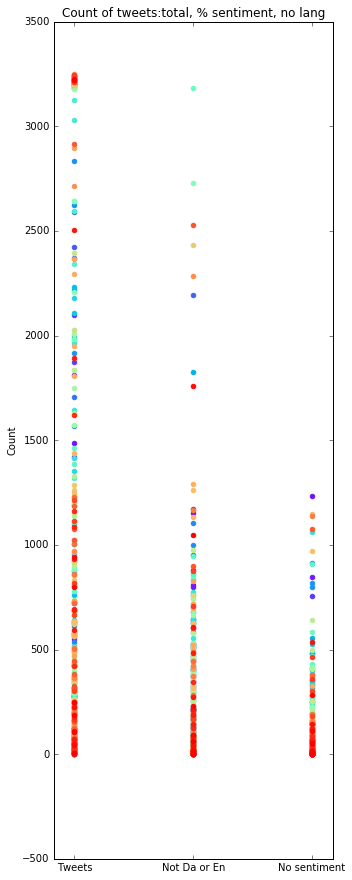

In [17]:

#plotting each user as a color on the three bars
ys = list_all
x = range(0,3)
plt.figure(figsize=(5, 15), dpi=20)
bar_text = ('Tweets','Not Da or En', 'No sentiment')
plt.xticks(x, bar_text, size='medium')
plt.ylabel('Count')
plt.title('Count of tweets:total, % sentiment, no lang')
plt.xticks(x, bar_text)
colors = cm.rainbow(np.linspace(0, 1, len(list_all)))
for y, c in zip(ys, colors):


    plt.scatter(x, y, color=c)
#print dict_score.values()


From this plot it is clear that there is a combination of amout of tweets and how many with no sentiment and how many that were not guessed as danish or english. This was quite as expected. 
To see if the sentiment score has anything to with the amount of tweets, a graph awas created to see if there were any correlation. As shown before there is not really any combination between the two, which was unexpected. 

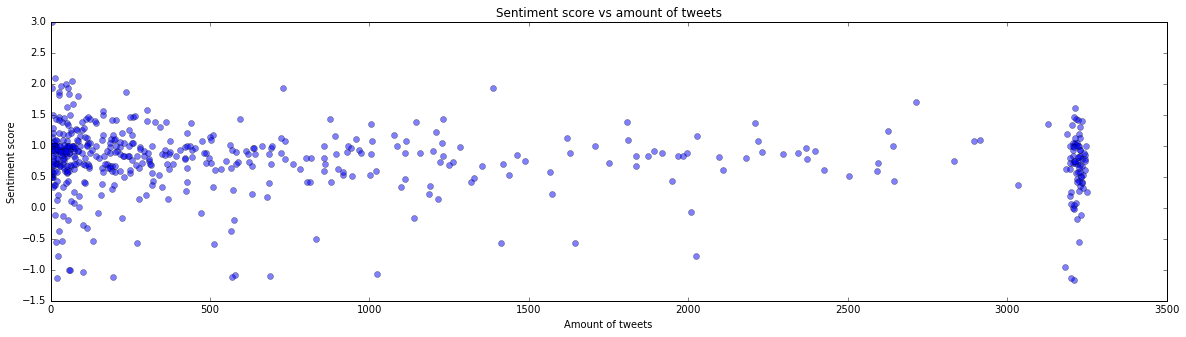

In [18]:
plt.figure(figsize=(20, 5), dpi=80)
x = amount
y = scores
plt.plot(x, y, 'o',alpha=0.5)
#plt.xlim( 0,3500 )
plt.title('Sentiment score vs amount of tweets')
plt.ylabel('Sentiment score')
plt.xlabel('Amount of tweets')

As mentioned in the Motivation, the tweets were selected instead of SO text, below is a small example of how the sentiment would be for SO text. First the text from answers are retrieved and afterwards it is cleaned and a score is determined. 

In [100]:

#getting the answer text from a certain user in stackoverflow
def get_answer(usernr, userfile):
    i = 1
    url = 'https://api.stackexchange.com/2.2/users/'+ str(usernr) + '/answers?order=desc&sort=activity&filter=withbody&site=stackoverflow&page=1&pagesize=100'
    r = requests.get(url)
    binary = r.content
    output = json.loads(binary)
    #saving it to a file
    with io.open(userfile , 'wb') as f:
        for j in range(len(output['items'])):
            body = output['items'][j]["body"]
            f.write(body)
        
        if output['has_more'] == True:
            i += 1
            url ='https://api.stackexchange.com/2.2/users/'+ str(usernr) +'/answers?order=desc&sort=activity&filter=withbody&site=stackoverflow&page=' + str(i) + '&pagesize=100'
            r = requests.get(url)
            binary = r.content
            output = json.loads(binary)    
            for i in range(len(output['items'])):
                body = output['items'][i]["body"]
                text = f.write(body)
    return  i
                


In [94]:
def get_score_stack(userfile):
    
    with io.open(userfile, 'rb') as stack_file:
        text =stack_file.read().replace('\n', '')
        text_clean = re.sub(r'\W+', ' ', text)
        text_ = re.sub(r"http\S+", "",text_clean)
    #print text_
        score_stack = sentiment_score(text_, s1_sentiment)
        score_ = convert_score(score_stack)
    return score_


In [102]:
#testing the methods 
user_1 = 'ploeh.txt'
user_2 = 'Hanspagh.txt'

print 'amount of tweets for user 1: ', len(get_tweets('ploeh.txt')), 'pages of answer: ', 1+get_answer(126014, 'body_ploeh.txt')

print 'user 1 is scoring: ', get_score_stack('body_ploeh.txt'), 'on his answers in SO'
print 'user 1 is scoring: ', dic[user_1], 'on his tweets'


print 'amount of tweets for user 1: ', len(get_tweets('Hanspagh.txt')), 'pages of answer: ', 1+get_answer(3286944, 'body_Hanspagh.txt')

print 'user 2 is scoring: ', get_score_stack('body_Hanspagh.txt'), 'on his answers in SO'
print 'user 2 is scoring: ', dic[user_2], 'on his tweets'


amount of tweets for user 1:  3217 pages of answer:  100
user 1 is scoring:  1 on his answers in SO
user 1 is scoring:  0.56 on his tweets
amount of tweets for user 1:  26 pages of answer:  2
user 2 is scoring:  1 on his answers in SO
user 2 is scoring:  1.21 on his tweets


It is clear that with two user who have many or few tweets the sentiment get the same. Of course it is worth  mentioning that the function is using the convertion function, that is only returning whole numbers, no decimal. But when compared to the two users sentiment on tweets it is clear that this way of getting sentiment would be quite uninformative. When asking something in a semiproffessionel enviroment such as SO, a user would want to formulate himself politely to possible get as much help as possible, besides when answering questions on SO, it is something you decided to do, so you would answer nicely in hopes of getting your answer upvoted and therby getting a higher reputation. 

To round up the sentiment part before jumping to network analysis, a moving average of sentiment has been made for two users. 
One user who has english tweets and one who has danish and both of them are the top tweeting users.

In [105]:
# getting language of a english tweeter, with many tweets
data_NA = get_tweets('NA.txt')
text_NA = ' '.join(data_NA)
# getting language of a hopefully danish user 
data_Riis = get_tweets('risagerlarsen.txt')
text_Riis = ' '.join(data_Riis)
print 'Language for NA: ', guessLanguage(text_NA)
print 'Language for Riis: ', guessLanguage(text_Riis)



Language for NA:  en
Language for Riis:  da


In [107]:
#Method for moving average based on window size, user and sentiment. 
def moving_average(user, window, sentiment):
    list_moving_average = []
    #first we need to split the data based on a window size    
    data = get_tweets(user)
    for x in xrange(0, len(data),window):
        data_chunk = data[x:x+window] 
        text_chunked = ' '.join(data_chunk)
        #then we get the moving average and append it to a list
        moving_average = sentiment_score(text_chunked,sentiment)
        list_moving_average.append(moving_average)
    return list_moving_average


Using trial and error, different sizes of windows were tested

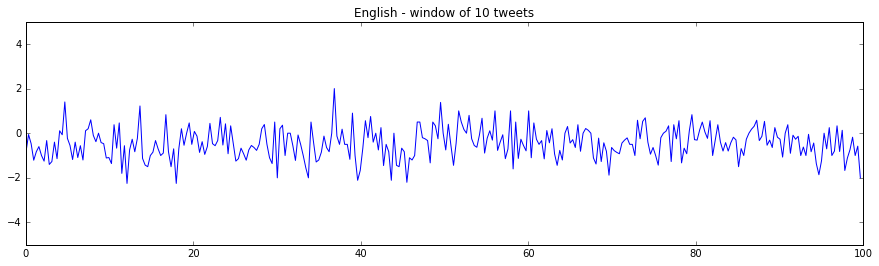

In [113]:

#This is based on UK sentiment
list_10_en = moving_average('NA.txt', 10, UK_sentiment)

plt.figure(figsize=(15, 4), dpi=80)
plt.plot(np.arange(0,101,100.0/len(list_10_en))[0:len(list_10_en)],list_10_en)
        
plt.ylim(-5,5 )
plt.xlim( 0,100 )
plt.title( 'English - window of 10 tweets')
plt.legend()
plt.show()

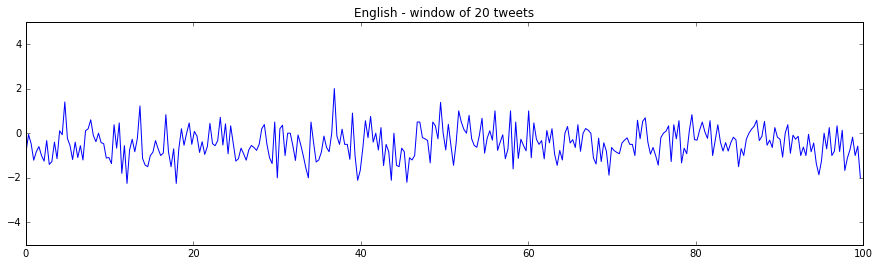

In [114]:

#This is based on UK sentiment
list_10_en = moving_average('NA.txt', 10, UK_sentiment)

plt.figure(figsize=(15, 4), dpi=80)
plt.plot(np.arange(0,101,100.0/len(list_10_en))[0:len(list_10_en)],list_10_en)
        
plt.ylim(-5,5 )
plt.xlim( 0,100 )
plt.title( 'English - window of 20 tweets')
plt.show()

error, no value


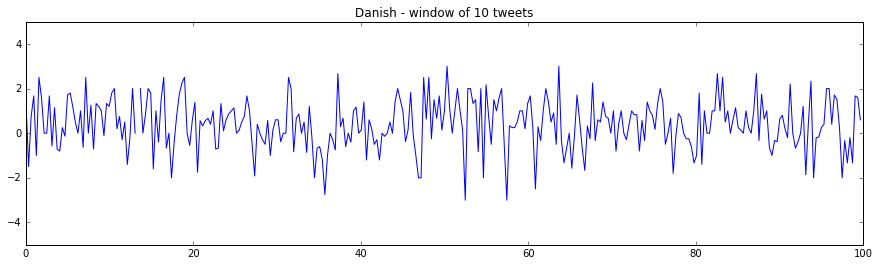

In [115]:
list_10_da = moving_average('risagerlarsen.txt', 10, dk_sentiment)

plt.figure(figsize=(15, 4), dpi=80)
plt.plot(np.arange(0,101,100.0/len(list_10_da))[0:len(list_10_da)],list_10_da)
        
plt.ylim(-5,5 )
plt.xlim( 0,100 )
plt.title( 'Danish - window of 10 tweets')

plt.legend()
plt.show()

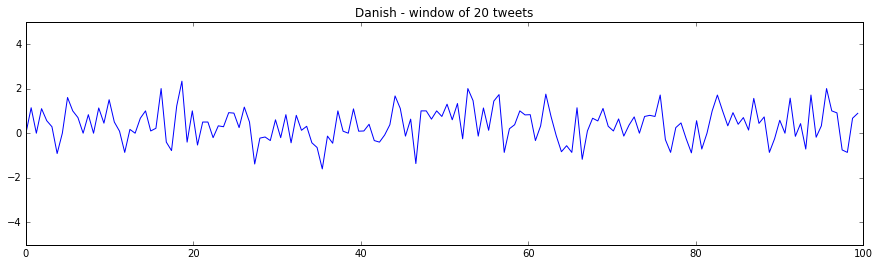

In [116]:
list_20_da = moving_average('risagerlarsen.txt', 20, dk_sentiment)

plt.figure(figsize=(15, 4), dpi=80)
plt.plot(np.arange(0,101,100.0/len(list_20_da))[0:len(list_20_da)],list_20_da)
        
plt.ylim(-5,5 )
plt.xlim( 0,100 )
plt.title( 'Danish - window of 20 tweets')

plt.legend()
plt.show()


What is interesting about these moving averages is that the danish actually seems to be more varied than the english, which was not expected, since danes are a bit more restricted i their communication. However it might be due to the fact that the english tweets are probarbly mostly done by danes, meaning that it is not in their mother tongue. This could e a reason to keep it more neutral. Besides the reason for tweeting in english might be due to a proffesional network kept on twitter as well, which explains that it is neutral. It is however not surpricing that the danish tweets are a bit more negative than teh english, both due to the above and due to danish people being good at complaining. 

***

### Network analysis

The second important part of this project was the analysis of the Danish SO community network. There were a lot of discusions of what would be more meaningful to use for generating networks from the SO data: should a bipartite network of users and tags be constructed? should users or tags be nodes? and how should they be connected? 

Looking at the four hypotheses stated in the begining of the project, what was needed was to :
- investigate what programming languages are most "important" or most "central"
- look at the correlation between the happiness score and a number of facts:
        - number of programming languages of users, type of programming languages
        - the number of answers, accepted anwers, reputation   

The networks that will be explored and analysed further on are therefore: a network of users connected by tags they share and a network of tags connected by the users sharing them. 

#### Network 1 -  Top 10 tags from all users as nodes; users share two tags (nodes) as edges.

The first network to look into is the tags network. However, given the huge amount of unique tags - 16395 - not all tags will be considered. They are be filtered by frequency, for each user. Therefore for each user his top 10 tags are selected to become nodes in this network. 

There are a number of steps in creating the newtork. First, a list of top tags for all users is generated:  

In [7]:
#the n parameter defines how many top tags are included 
#a n=10 will result in a total of 34044, of which 5763 unique tags 
#a n=20 will result in a total of 53927, of which 8049 unique tags 
n=10

user_top_tags_list=[]
all_top_tags=[]

#make dictionary of user id and their top tags 
for user in users:
    with open('tags/'+user+'.csv', 'rt') as tags_csv:
        tag_reader = csv.reader(tags_csv)
        
        #get the first n lines (the top tags) - the csv files for tags are sorted desc by tag count
        tagdata = list(islice(tag_reader, n))        
        top_tags=[tagd[0] for tagd in tagdata]
        
        #add the tags to the list of all tags
        all_top_tags.extend(top_tags)
        
        user_top_tags_tuple=(user,top_tags)
        user_top_tags_list.append(user_top_tags_tuple)
        
users_top_tags_dict=dict(user_top_tags_list)
top_tags_set=set(all_top_tags)

In [12]:
print "Total top tags for all users: ", len(all_top_tags)
print "Unique number of tags - the number if nodes for the network: ", len(top_tags_set)

Total top tags for all users:  34044
Unique number of tags - the number if nodes for the network:  5763


The top_tags_set gives the nodes of the network. For defining edges between two nodes, the intersection of the list of users both nodes is calculated. If the intersection is not empty (that is, the nodes "share" at least one user), an edge is added between the two nodes. The weight of the edge is set to be the number of users the two nodes "share".

In [8]:
#create a dictionary where the key is a top tag and the value is a list of users having the top tag
tag_user_dicts=[]
for tag in top_tags_set:
    user_list=[user for user,tag_list in users_top_tags_dict.items() if tag in tag_list]
    tag_user_dict=(tag,user_list)
    tag_user_dicts.append(tag_user_dict)
top_tags_users_dict = dict(tag_user_dicts)

In [9]:
#the graph
#creating the graph:
G_top_tags=nx.Graph()

#adding nodes:
for tag in top_tags_set:
    G_top_tags.add_node(tag)

#adding edges:
for tag1 in top_tags_set:
    for tag2 in top_tags_set:
        if tag1==tag2:
            continue #we don't want self loops
        else:
            #check if there are any common users
            if (len(set(top_tags_users_dict.get(tag1)).intersection(top_tags_users_dict.get(tag2)))): 
                #if so, add a path
                G_top_tags.add_path([tag1,tag2]) 
                #and set the edge data
                G_top_tags[tag1][tag2]['common_users'] =  list(set(top_tags_users_dict.get(tag1)).intersection(top_tags_users_dict.get(tag2))) 
                #set edge weight                                             
                G_top_tags[tag1][tag2]['weight'] = len(G_top_tags[tag1][tag2]['common_users']) 

The resulted graph has 5763 nodes and 78415 weighted edges. 

In [15]:
print G_top_tags.number_of_nodes(),"nodes"
print G_top_tags.number_of_edges(),"edges"

5763 nodes
78415 edges


To analyse the importance of different language, we next inspect some important network measurement. First, we look at the degree distribution. Then we inspect centrality, calculating betweenness and eigen vector centralities.

**Degree distribution of tags network **








In [10]:
weight_deg =nx.degree(G_top_tags, weight='weight')

In [24]:
max(weight_deg.values())

9555

Bellow the degree distribution is ploted in the actual scale:

In [11]:
#defining the histograms
hist = np.histogram(weight_deg.values(), bins=range(1,max(weight_deg.values())+1))

#zoom in, taking the first degree values
#hist = np.histogram(weight_deg.values(), bins=range(100))

x = hist[1]
y = hist[0]

trace0 = go.Bar(
    x = x,
    y = y,
    marker=dict(
        color='rgb(49,130,189)'
    )
)

data = [trace0]
layout =go.Layout(
    xaxis = dict(
        tickangle=0,
        title = "Degree"
    ),
    yaxis = dict(
        title = "Occurences"
    ),
    barmode = 'group',
    title = "Tags network degree distribution",
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Degree distribution in tags network')

To observe the nature of the distribuiton better, a log-log scale plot is provided bellow.  

In [12]:
hist = np.histogram(weight_deg.values(), bins=range(1,max(weight_deg.values())+1))
trace1 = go.Scatter(
x = hist[1],
y = hist[0],
mode = 'markers',
name = 'markers'
)
data = [trace1]
layout = go.Layout(
    xaxis=dict(
        type='log',
        autorange=True
    ),
    yaxis=dict(
        type='log',
        autorange=True
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


Looking at the above plot and observing the initial curve (between 1-10 on the x scale), one could be tempted to estimate the distribution to a Poisson distribution. However, the Poisson distribution observable in the random network model underestimates the size and the frequency of the high degree nodes. This is as well easy to observe in the graph above, where the second pattern describes more of a power-law distribution, observable in scale free networks. 

Two more centrality measures are next analysed: betweeness and eigen vector centralities [13]. 

The betweennes centrality of a node is dependent to the number of shortest paths from all nodes to all others nodes that pass through that node. A node with high betweenness centrality has a large influence on the transfer of items through the network. 

In this newtork of tags, a high betweenness centrality would indicate a technology that is sort of a "bridge" or a prerequisite to learn another technology. 

Eigen vector centrality is again a measure of the influence of a node in a network, looking at the types of nodes a node is connected too. If a node has many connections and these connections are isolated, it doesn't mean the node is necesary central (even if its degree centrality is high). In contrast, if a node is connected to other powerful nodes, with many connections, the node is indeed central (its eigen vector centrality is high).

In this network a high eigen centrality would indicate a tag that is highly connected to the most popular languages in the danish SO community.  

In [37]:
#calculate betweenness centrality and print the top 10 tags:
btw=nx.betweenness_centrality(G_top_tags)
#for key, value in sorted(btw.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:10]:
    #print "%s: %s" % (key, value)

|Tag|Betweenness centrality|                                
|--|-------------------------------|                        
|C#|0.138591926034|
|javascript|0.107253405217|
|java|0.0897250201117|
|php|0.0699683987781|
|android|0.0531741089897|
|pyhton|0.0528487548262|
|jquery|0.049210228049|
|html|0.0368605171323|
|ios|0.030129660279|
|mysql|0.0285724541454|




In [38]:
#calculate eigen vector centrality and print the top 10 tags:
eig = nx.eigenvector_centrality(G_top_tags)
#for key, value in sorted(eig.iteritems(), key = lambda (k,v): (v,k), reverse = True)[:10]:
    #print "%s: %s" % (key, value)

|Tag|Eigen vector centrality|                                
|--|-------------------------------|                        
|javascript|0.443654367319|
|jquery|0.382305259561|
|html|0.366523936665|
|php|0.323453285964|
|css|0.28863066822|
|C#|0.276707511735|
|mysql|0.201935867026|
|asp.net|0.173821206975|
|.net|0.154142603469|
|java|0.148577098286|





Another measurement interesting to look at is the assortativity coefficient. This lies between −1 and 1. When r = 1, the network is said to have perfect assortative mixing patterns, when r = 0 the network is non-assortative, while at r = −1 the network is completely disassortative [13].

The degree assortativity coefficient is negative , but close to 0. This means that there is a small tendency for high-degree tags to link to low-degree tags. This observation could be the natural effect of the SO tag system: there are a huge number of tags, very specialised for particular problems, within different programming languages and paradigms; moreover anyone can add a new tag, a fact that favors the creation of low degree tags. 

In [22]:
assort = nx.degree_assortativity_coefficient(G_top_tags)
print "Degree assortativity coefficient is: ", assort

Degree assortativity coefficient is:  -0.200191734028


Finally, a community analysis was made on the tags graph, using the Python Louvain-algorithm implementation [14]. First the modularity of the community partition was calculated. The 0.33 value is indicating a fair optimisation of tags community division, given the fact that tags communities overlapp a lot: for example general programming elements like regex or arrays would be present in many or all communities.

In [40]:
partition = community.community_louvain.best_partition(G_top_tags)
modularity = community.community_louvain.modularity(partition,G_top_tags)
print modularity

0.33390997231


In [43]:
communities=defaultdict(list)
for key, value in sorted(partition.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    communities[value].append(key)

for key in communities:
    print len(communities[key])," tags in community : ",key

#uncomment the code bellow to print all the communities 
#    print communities[key]

1141  tags in community :  0
1386  tags in community :  1
1116  tags in community :  2
1240  tags in community :  3
3  tags in community :  4
279  tags in community :  5
457  tags in community :  6
63  tags in community :  7
9  tags in community :  8
8  tags in community :  9
7  tags in community :  10
24  tags in community :  11
6  tags in community :  12
1  tags in community :  13
1  tags in community :  14
3  tags in community :  15
2  tags in community :  16
1  tags in community :  17
4  tags in community :  18
3  tags in community :  19
1  tags in community :  20
1  tags in community :  21
2  tags in community :  22
1  tags in community :  23
1  tags in community :  24
1  tags in community :  25
1  tags in community :  26
1  tags in community :  27


The Pyhton Louvain algorithm detected 28 communities. An example community is shown below. The community seems to encorporate various media technologies for web solutions like flash / actionscript programming , stage, stage3d and their specific components: itemrendered, audio, gradients, geocode, etc

In [47]:
print communities[7]

['youtube-channels', 'typoscript', 'typo3-7.x', 'typo3-7.6.x', 'typo3-6.2.x', 'typo3-6.1.x', 'typo3', 'timeline', 'starling-framework', 'stage3d', 'stage', 'spectrum', 'setsockopt', 'sendto', 'rtmfp', 'rosetta-stone', 'remote-desktop', 'recordset', 'rampart', 'ping', 'pci-e', 'pci-bus', 'pci', 'multicast', 'mismatch', 'linear-gradients', 'jsfl', 'itemrenderer', 'introspection', 'ico', 'html5-audio', 'hook', 'greasemonkey', 'gradients', 'gecode', 'flux', 'fluid', 'flex4.5', 'flex4', 'flex3', 'flex', 'flash-player', 'flash-media-server', 'flash-cs5', 'flash-builder', 'flash', 'file-get-contents', 'fedext', 'favicon', 'extbase', 'dos', 'cumulus', 'constraint-programming', 'code-injection', 'code-golf', 'bootloader', 'axis2', 'amf', 'air', 'adobe', 'actionscript-3', 'actionscript-2', 'actionscript']


Finally, given the great amount of nodes (5763) and edges (78415), the network of tags is not being ploted here. A plot will be provided for the network of users. 

###  Network 2 - users with more than 50 analysed tweets as nodes, tags shared as edges

The second graph analysed is formed by taking users as nodes and the tags they have in common as a basis for generating edges. As we want to inspect the correlation between the network analysis results and the sentiment analysis for different users, some filtering of users was needed. 

First of all, only users with a twiter account associated were considered. Out of those, only users with a sufficient amount of tweets needed to be selected. However, the sentiment analysis function may fail to recognize 

* the language of the tweets
* the sentiment of the tweets

To deal with this problem and at the same time make it more meaningful, users were filtered based on the number of tweets successfully analysed by the sentiment analysis function. Therefore, only users with more than 50 succesfully analysed tweets were considered, resulting in a number of 380 nodes

In [31]:
#make a dictionary of SO username as key and the number of tweets as value
with open('twitterfile.csv', mode='r') as infile:
    reader = csv.reader(infile)
    so_twitter_usernamedict = {rows[0]:rows[1].rsplit('/', 1)[-1] for rows in reader}

#retrieve the number of tweets a user has by using the get_tweets function and calling the len of its result    
user_no_tweets_dict ={k:len(get_tweets(v+'.txt')) for k, v in so_twitter_usernamedict.iteritems() if k!='user'}

#pickle the dict for later use
pickle.dump(user_no_tweets_dict, open("user_tweets_number.p","wb"))

First the users having "None" as value (meaning that the language of his tweets could not be guessed - for example there is a user tweeting in German) are filtered out. 

In [57]:
#use the dict generated by the sentiment analysis to filter out users whose tweets language was not guessed 

#unpickle the user - tweet happines scores dict
sentiment_tweets_dict = pickle.load(open("dict_user.p", "rb"))
sentiment_tweets_dict1 = {key : val for key ,val in sentiment_tweets_dict.items() if val != None}

Next the number of tweets for which the happiness score was succesfully computed needed to be calculated. This is done by substracting the number of tweets that could not be guessed as english/danish and the number of tweets with no sentiment attached from the total number of tweets for each user. 

In [28]:
user_calculated_tweets = {}

# Fill in the entries one by one
for user in sentiment_tweets_dict1:
    user_calculated_tweets[user.replace('.txt', '')] =  len(get_tweets(user)) - sentiment_tweets_dict1[user][1] - sentiment_tweets_dict1[user][2]

Finally the dictionary is sorted and only the users that have more than 50 tweets for which the hapiness score was calculated are taken to use in building the final graph. The dictionary was pickled, for later use.

In [29]:
sorted_dict = sorted(user_calculated_tweets.items(), key=operator.itemgetter(1), reverse=True)
calculated_tweets_above50 = [item for item in sorted_dict if item[1]>50]

#pickle the dict
pickle.dump(calculated_tweets_above50, open("user_calculated_tweets.p","wb"))

Based on this list of twitter users, the SO ids were then extracted, to be used as nodes labels 

In [32]:
#get SO usernames based on twitter usernames
nodes_twitter=[k for k,v in so_twitter_usernamedict.iteritems() for user in calculated_tweets_above50 if v==user[0]]

#get SO ids based on SO usernames
so_id_name_dict={v: k for k, v in dict(user_ids).iteritems()}

#get the list of nodes
nodes_ids = [so_id_name_dict.get(user) for user in nodes_twitter]

For the edges, not all tags were taken either. Instead, we were interested in the programming languages a user is associated to, in order to be able to make asumptions about the correlation between happiness scores and the usage of a language. At the same time, this choice offers an further insight on the different programming languages usage and their popularity among Danish users.

A list of programming languages was needed, to compare against the tags a user has. The intuitive idea was to get the Wikipedia List of Programming Languages (https://en.wikipedia.org/wiki/List_of_programming_languages). However, this list contains 600+ programming languages, some of which are not even in use (anymore). 

The approach taken intead was to create a list of programming languages that would contain the relevant ones for the problem. The list is based on two things:
- The need to identify the most important programming languages. Therefore the programming languges listed in the lists bellow were considered: 
    - the most popular technologies of the 2016 Stackoverflow developer survey https://stackoverflow.com/research/developer-survey-2016#technology
    - the top tags on Stackoverflow: http://data.stackexchange.com/stackoverflow/query/576672
    - the most popular programming languages on Github http://githut.info/
    - the TIOBE index https://en.wikipedia.org/wiki/TIOBE_index 
    - the RedMonk Programming Language Rankings: http://redmonk.com/sogrady/2016/07/20/language-rankings-6-16/

- The need to identify the ones more relevant for the network of danish programmers. The top 100 popular tags in the Danish Stackoverflow were "manually" filtered for programming languages and important technologies (like Git, Wordpress - even if not programming languages, they are important technologies, widely used.)

The final list, consisting of 92 technologies, is given bellow.

In [19]:
technologies=['JavaScript','SQL','Java','C#','PHP','Python','C++','C','Node.js','AngularJS','Ruby',
              'Objective-C','Delphi','TypeScript','Bash','Groovy','Lua', 'PowerShell', 'Drupal', 'Elixir', 'Fortran',
              'Erlang','PL/SQL','HTML','CSS','PostgreSQL','Kotlin','D','Elm','Julia','Lisp','OCaml','Xamarin','Unity',
              'Meteor','aurelia','Rust','Swift','F#','Scala','Go','Clojure','React','Haskell','Visual Basic','WordPress',
              'Matlab','Sharepoint','CoffeeScript','LAMP','Cordova','Salesforce','Perl','Android','MongoDB', 'Arduino ',
              'Raspberry Pi','iOS','JQuery', 'Git', 'MySQL','.NET', 'Ruby on Rails','R','JSON','Linux','ASP.NET','Spark',
              'Cloud', 'Redis','Hadoop', 'Shell', 'SAS','ABAP','Dart','Scratch','COBOL','Transact-SQL','LabVIEW','Ada',
              'Logo','Prolog','Scheme','MQL4','Apex','Awk','VHDL','Alice', 'AJAX', 'Excel','Azure','ActionScript']

In [33]:
#first lower case the list of techs
techs = [x.lower() for x in technologies]
user_tech_list=[]

#create a dictionary where the key is a user and the value is the list of technologies tags the user has 
for user in nodes_ids:
    f = open('tags/'+user+'.csv')
    reader = csv.reader(f)
    tech_tags=[row[0].lower() for row in reader if (row[0].lower() in techs)]    
    tech_tuple=(user,tech_tags)
    user_tech_list.append(tech_tuple)
users_languages_dict=dict(user_tech_list)

In [34]:
#create a dictionary where the key is a language and the value is a list of users having the language tag
user_dicts=[]
for tech in techs:
    user_list=[user for user,language_list in users_languages_dict.items() if tech in language_list]
    user_dict=(tech,user_list)
    user_dicts.append(user_dict)
language_users_dict = dict(user_dicts)

In [35]:
#creating the graph:
G_users=nx.Graph()

#adding nodes:
for user in nodes_ids:
    G_users.add_node(user)

As with the previous graph, to generate an edge between two users, we take the intersection of the sets of tech tags the users have

In [36]:
for user1 in nodes_ids:
    for user2 in nodes_ids:
        if user1==user2:
            continue #we don't want self loops
        else:
            #check if there are common tags
            if (len(set(users_languages_dict.get(user1)).intersection(users_languages_dict.get(user2)))): 
                #if so, add a path
                G_users.add_path([user1,user2]) 
                #and set the edge data
                G_users[user1][user2]['common_tags'] =  list(set(users_languages_dict.get(user1)).intersection(users_languages_dict.get(user2))) 
                #set edge weight                                             
                G_users[user1][user2]['weight'] = len(G_users[user1][user2]['common_tags']) 

In [70]:
print G_users.number_of_nodes()
print G_users.number_of_edges()

380
30061


In [78]:
max(deg_userGraph.values())

303

Again, some important network measures are investigated. Firstly, the (simple, no weights considered) degree distribution is ploted below:

In [37]:
#the array holding the degrees
deg_userGraph =nx.degree(G_users)

#defining the histograms
hist = np.histogram(deg_userGraph.values(), bins=range(1,max(deg_userGraph.values())+1))

#zoom in, taking the first degree values
#hist = np.histogram(weight_deg.values(), bins=range(100))

x = hist[1]
y = hist[0]

trace0 = go.Bar(
    x = x,
    y = y,
    marker=dict(
        color='rgb(49,130,189)'
    )
)

data = [trace0]
layout =go.Layout(
    xaxis = dict(
        tickangle=0,
        title = "Degree"
    ),
    yaxis = dict(
        title = "Occurences"
    ),
    barmode = 'group',
    title = "Users network degree distribution - without weights",
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Degree distribution in users network')

In [38]:
#the weighted degrees
weight_deg_userGraph =nx.degree(G_users, weight='weight')

#defining the histograms
hist = np.histogram(weight_deg_userGraph.values(), bins=range(1,max(weight_deg_userGraph.values())+1))

#zoom in, taking the first degree values
#hist = np.histogram(weight_deg.values(), bins=range(100))

x = hist[1]
y = hist[0]

trace0 = go.Bar(
    x = x,
    y = y,
    marker=dict(
        color='rgb(49,130,189)'
    )
)

data = [trace0]
layout =go.Layout(
    xaxis = dict(
        tickangle=0,
        title = "Degree"
    ),
    yaxis = dict(
        title = "Occurences"
    ),
    barmode = 'group',
    title = "Users network degree distribution - weights considered",
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Degree distribution in tags network')

Finally, in log-log scale: 

In [39]:
hist = np.histogram(deg_userGraph.values(), bins=range(1,max(deg_userGraph.values())+1))
trace1 = go.Scatter(
x = hist[1],
y = hist[0],
mode = 'markers',
name = 'markers'
)
data = [trace1]
layout = go.Layout(
    xaxis=dict(
        type='log',
        autorange=True
    ),
    yaxis=dict(
        type='log',
        autorange=True
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Looking at the degree distribution ploted above, both for simple and weighted degrees, no obvious pattern of the data points. Unlike the previous network degree distribution, here there is no power law or poisson indicator. The reason for this might be the nature of the network. The users do not necesarily link to other users trough the tags, the same way as tags does with users. Besides the tags linking users are only the programming language tags, which means that if all tags were used as links the distribution would be more similar to the previous graph.  

To understand this network, it made sense to look at the eigen vector centrality and the betweenness centrality. In this graph a high eigenvector centrality would mean that the user is well connected to high degree nodes, which in this case would indicate that a user is connected to other users who uses a lot of the "popular" programming languages. This means that the sentiment of that user would indicate if you coding in the most popular languages makes you happy. The betweenness centrality would mean that you are coding in languages which are well connected to all the other languages. 

In [84]:
btw_users=nx.betweenness_centrality(G_users)
for key, value in sorted(btw_users.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:10]:
    print "%s: %s" % (key, value)

1009465: 0.00594928661685
13627: 0.00557522043555
79061: 0.00497462569112
1841839: 0.00390699452293
33213: 0.00368412280313
190822: 0.00352371084564
519836: 0.00336994820151
126014: 0.0031362499367
218589: 0.00306769144912
226394: 0.00297223948547


In [85]:
eig_users = nx.eigenvector_centrality(G_users)
for key, value in sorted(eig_users.iteritems(), key = lambda (k,v): (v,k), reverse = True)[:10]:
    print "%s: %s" % (key, value)

13627: 0.144284085389
218589: 0.139064556326
79061: 0.136987682717
28004: 0.135569554758
1841839: 0.13378318273
33213: 0.126488206261
519836: 0.120170562138
561545: 0.117452562884
871985: 0.115998759654
170196: 0.115273222767


In respects to assortativity, the network is disassortative, meaning that high degree nodes tend to connect to low degree nodes. This could be explained by the fact that high degree nodes are users who know a lot of languages and contribute to many answers, including answering low degree nodes questions. 

In [86]:
assort = nx.degree_assortativity_coefficient(G_users)
print assort

-0.182284296245


In [40]:
partition_users = community.community_louvain.best_partition(G_users)
modularity_users = community.community_louvain.modularity(partition_users,G_users)
print modularity_users

0.077808312999


In [42]:
communities_users=defaultdict(list)
for key, value in sorted(partition_users.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    communities_users[value].append(key)

for key in communities_users:
    print len(communities_users[key])," users in community. : ",key
    
    #uncode the code bellow to print the actual communities
    #print communities_users[key]

1  users in community. :  0
121  users in community. :  1
1  users in community. :  2
93  users in community. :  3
1  users in community. :  4
1  users in community. :  5
1  users in community. :  6
93  users in community. :  7
1  users in community. :  8
1  users in community. :  9
1  users in community. :  10
1  users in community. :  11
1  users in community. :  12
1  users in community. :  13
1  users in community. :  14
1  users in community. :  15
1  users in community. :  16
1  users in community. :  17
1  users in community. :  18
1  users in community. :  19
1  users in community. :  20
1  users in community. :  21
1  users in community. :  22
1  users in community. :  23
1  users in community. :  24
1  users in community. :  25
1  users in community. :  26
1  users in community. :  27
1  users in community. :  28
1  users in community. :  29
1  users in community. :  30
1  users in community. :  31
1  users in community. :  32
1  users in community. :  33
1  users in communit

An example community is shown below:

In [45]:
community3= communities_users[3]
print community3

['95176', '936408', '920464', '874548', '8418', '796559', '79061', '790474', '78336', '753001', '746764', '705741', '705602', '6736063', '655548', '652546', '642148', '6262429', '6120097', '5910058', '5780545', '564779', '5219154', '5110381', '499156', '4961087', '4882647', '4849798', '4768618', '4636578', '4600911', '4499437', '415025', '4145708', '3945914', '3878063', '3592403', '3535616', '348946', '342437', '33213', '3104775', '2972', '291889', '2912892', '2759841', '2757005', '2722789', '266541', '2501509', '246234', '24218', '2412477', '2328637', '2317519', '2308514', '226394', '218589', '2181676', '202538', '1941038', '190822', '190599', '1841839', '1840269', '1802429', '1703802', '1700737', '1699360', '1572847', '1569350', '1514022', '1471464', '144433', '143686', '1403403', '1389357', '13627', '1339323', '13372', '1335765', '1315347', '1309868', '1290601', '1242637', '1161584', '1161518', '1118969', '1103925', '1064689', '1046515', '1017985', '1009465']


In [117]:
#function to retrieve user names based on user nr. 
def get_username(number):                
    with open( "QueryResults.csv", "rb") as query_file:
        reader = csv.DictReader(query_file)
        for row in reader:
            u_name = row ['DisplayName']
            u_number = row['User Link']
            if u_number == (number):
                name = u_name
                return  name


In [118]:
#function to retrieve tweet based on user name
def get_tweetname(name):
    with open( "twitterfile.csv", "rb") as twitter_file:
        reader = csv.DictReader(twitter_file)
        for row in reader:
            u_name_twitter = row['user'] 
            #print u_name_twitter
            raw_u_twitter = row['link']
            u_twitter =raw_u_twitter.rsplit('/', 1)[-1]
            
            if u_name_twitter == name:
                    return u_twitter + '.txt'

In [119]:
#getting happiness dict
happiness_raw = pickle.load(open("happiness_overall.p", "rb"))
happiness={key : val for key ,val in happiness_raw.items() if val != None}

In [120]:
#get dict that contains user id as key and happiness score as value
dict_score_nr = {user: happiness[get_tweetname(get_username(user))] for user in nodes_ids }

In [100]:
#printing an example of the new dict
dict_score_nr.items()[:10]

[('5303893', -0.33),
 ('4261813', 0.27),
 ('357130', 1.05),
 ('3535616', -0.77),
 ('1802429', 0.7),
 ('1522942', 1.47),
 ('1118969', 0.49),
 ('3263450', -0.02),
 ('202538', 1.36),
 ('1155902', 0.68)]

Now that the a dictionary is created with user id and score, it is time to look at the happiness and how ot affects the user. As shown below there is not really any concentration of happiness communities as such. The three communities generated previously all have a wide spread of happiness. So happiness does not define the communities. However they all have the same average happiness, so maybe programmers needs other programmers with contradictive sentiment around

In [125]:
#getting the top  10 lowest and highest sentimentscore within community 3
print 'Top 10 highest rated user:', sorted([dict_score_nr[k] for k in community3 if k in dict_score_nr], reverse= True)[:10]
print 'Top 10 lowest rated user:',sorted([dict_score_nr[k] for k in community3 if k in dict_score_nr])[:10]
print 'Average sentiment in community 3:', np.mean([dict_score_nr[k] for k in community3 if k in dict_score_nr])

Top 10 highest rated user: [2.0, 1.94, 1.82, 1.47, 1.41, 1.4, 1.4, 1.4, 1.38, 1.38]
Top 10 lowest rated user: [-1.09, -1.07, -0.95, -0.77, -0.56, -0.18, -0.17, -0.06, 0.06, 0.13]
Average sentiment in community 3: 0.705913978495


In [123]:
#getting the top  10 lowest and highest sentimentscore within community 7

community7 = communities_users[7]
print 'Top 10 highest rated user:',sorted([dict_score_nr[k] for k in community7 if k in dict_score_nr], reverse= True)[:10]
print 'Top 10 lowest rated user:',sorted([dict_score_nr[k] for k in community7 if k in dict_score_nr])[:10]
print 'Average sentiment in community 7:', np.mean([dict_score_nr[k] for k in community7 if k in dict_score_nr])

Top 10 highest rated user: [1.94, 1.93, 1.93, 1.58, 1.49, 1.48, 1.42, 1.41, 1.41, 1.38]
Top 10 lowest rated user: [-1.1, -1.03, -0.59, -0.17, -0.12, -0.08, -0.08, 0.04, 0.22, 0.32]
Average sentiment in community 7: 0.780860215054


In [124]:
#getting the top  10 lowest and highest sentimentscore within community 1
community1 = communities_users[1]
print 'Top 10 highest rated user:',sorted([dict_score_nr[k] for k in community1 if k in dict_score_nr], reverse= True)[:10]
print 'Top 10 lowest rated user:',sorted([dict_score_nr[k] for k in community1 if k in dict_score_nr])[:10]
print 'Average sentiment in community 1:', np.mean([dict_score_nr[k] for k in community1 if k in dict_score_nr])

Top 10 highest rated user: [1.71, 1.47, 1.44, 1.43, 1.43, 1.36, 1.33, 1.31, 1.3, 1.29]
Top 10 lowest rated user: [-1.16, -1.12, -0.57, -0.55, -0.54, -0.37, -0.2, -0.02, -0.0, 0.01]
Average sentiment in community 1: 0.734710743802


To understand what programming languages could make you happy, or more specifically to see if any specific language makes you happy, the top Betweenness and eigen vector centrality tags are used as a searchword to get user with that tag and then get teh average score of that group of users. 

In [134]:
top_tags_users_dict["java"]
mean_javascript = np.mean([dict_score_nr[k] for k in top_tags_users_dict["javascript"] if k in dict_score_nr])
print 'programming javascript makes you this happy:', mean_javascript
mean_java = np.mean([dict_score_nr[k] for k in top_tags_users_dict["java"] if k in dict_score_nr])
print 'programming java makes you this happy:', mean_java
mean_c= np.mean([dict_score_nr[k] for k in top_tags_users_dict["c#"] if k in dict_score_nr])
print 'programming c# makes you this happy:', mean_c
mean_php = np.mean([dict_score_nr[k] for k in top_tags_users_dict["php"] if k in dict_score_nr])
print 'programming php makes you this happy:', mean_php
mean_android = np.mean([dict_score_nr[k] for k in top_tags_users_dict["android"] if k in dict_score_nr])
print 'programming android makes you this happy:', mean_android
mean_python = np.mean([dict_score_nr[k] for k in top_tags_users_dict["python"] if k in dict_score_nr])
print 'programming python makes you this happy:', mean_python
mean_html = np.mean([dict_score_nr[k] for k in top_tags_users_dict["html"] if k in dict_score_nr])
print 'programming html makes you this happy:', mean_html
mean_ios = np.mean([dict_score_nr[k] for k in top_tags_users_dict["ios"] if k in dict_score_nr])
print 'programming ios makes you this happy:', mean_ios
mean_mysql = np.mean([dict_score_nr[k] for k in top_tags_users_dict["mysql"] if k in dict_score_nr])
print 'programming mysql makes you this happy:', mean_mysql
mean_jquery = np.mean([dict_score_nr[k] for k in top_tags_users_dict["jquery"] if k in dict_score_nr])
print 'programming jquery makes you this happy:', mean_jquery
mean_css = np.mean([dict_score_nr[k] for k in top_tags_users_dict["css"] if k in dict_score_nr])
print 'programming css makes you this happy:', mean_css
mean_asp = np.mean([dict_score_nr[k] for k in top_tags_users_dict["asp.net"] if k in dict_score_nr])
print 'programming asp.net makes you this happy:', mean_asp
mean_net = np.mean([dict_score_nr[k] for k in top_tags_users_dict[".net"] if k in dict_score_nr])
print 'programming .net makes you this happy:', mean_net


programming javascript makes you this happy: 0.79246031746
programming java makes you this happy: 0.7375
programming c# makes you this happy: 0.716129032258
programming php makes you this happy: 0.718860759494
programming android makes you this happy: 0.8512
programming python makes you this happy: 0.738
programming html makes you this happy: 0.69
programming ios makes you this happy: 0.756304347826
programming mysql makes you this happy: 0.799142857143
programming jquery makes you this happy: 0.758860759494
programming css makes you this happy: 0.714385964912
programming asp.net makes you this happy: 0.867441860465
programming .net makes you this happy: 0.705090909091


In [ ]:
# get the degrees
degrees = set(nx.degree(G_users,'weight').values())
#mapping = dict(zip(sorted(degrees),count()))
nodes = G_users.nodes()
colors = [G_users.degree(n,weight='weight') for n in nodes]
#[mapping[G_tags.degree(n,weight='weight')] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
#pos = nx.spring_layout(G_tags)
pos=graphviz_layout(G_users,prog="dot")
nx.draw_networkx_edges(G_users, pos, alpha=0.2)
nx.draw_networkx_nodes(G_users, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=50, cmap=plt.cm.jet)
plt.figure(figsize=(10,10))
plt.colorbar(colors)
#plt.axis('off')
plt.show()

In [170]:
dict_user_answer_rep={}
dict_user_answer={}
with io.open("users_answers.csv") as answers:
    reader = csv.DictReader(answers)
    for row in reader:
        #print row['User Link']
        dict_user_answer_rep[row['User Link']]= row['Reputation'] 
        dict_user_answer[row['User Link']] = row['Total Answers'] 
  
dict_answer = {k:v for k,v in dict_user_answer.iteritems() if k in dict_score_nr.keys()}

dict_reputation = {k:v for k,v in dict_user_answer_rep.iteritems() if k in dict_score_nr.keys()}

from collections import defaultdict

answer_happy = defaultdict(list)
for a, b in zip(dict_score_nr.items(), dict_answer.items()):
    answer_happy[a[1]] =b[1]
    

rep_happy = defaultdict(list)
for a, b in zip(dict_score_nr.items(), dict_reputation.items()):
    rep_happy[b[1]]=a[1]  

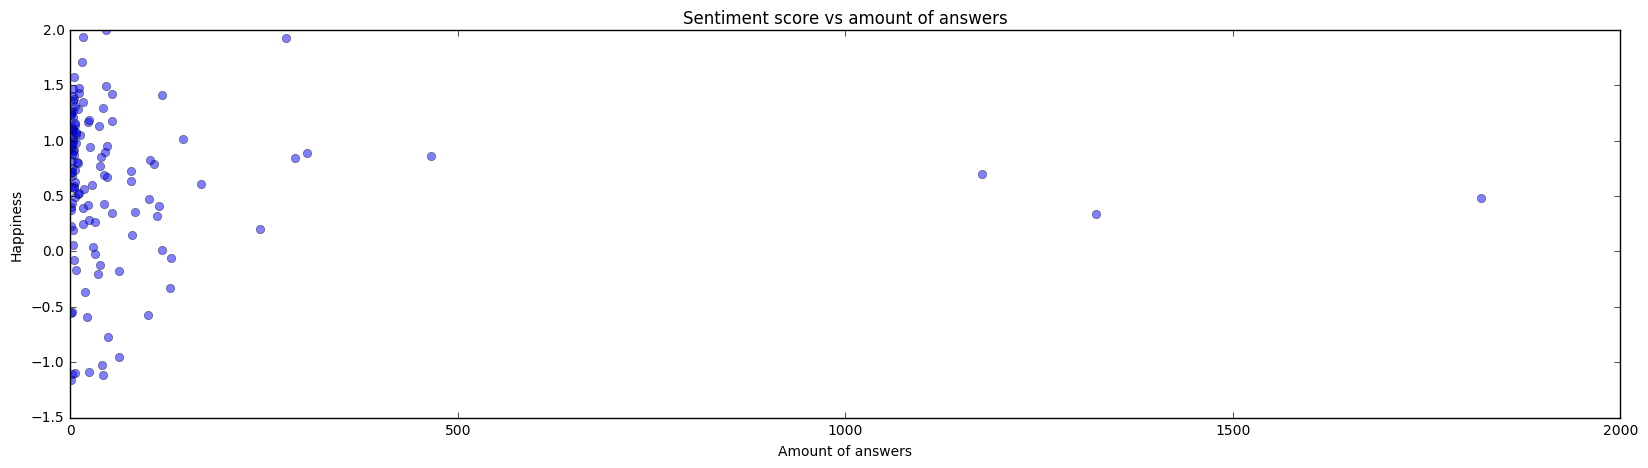

In [168]:
plt.figure(figsize=(20, 5), dpi=80)
x = answer_happy.values()
y = answer_happy.keys()
plt.plot(x, y, 'o',alpha=0.5)
#plt.xlim( 0,3500 )
plt.title('Sentiment score vs amount of answers')
plt.ylabel('Happiness')
plt.xlabel('Amount of answers')

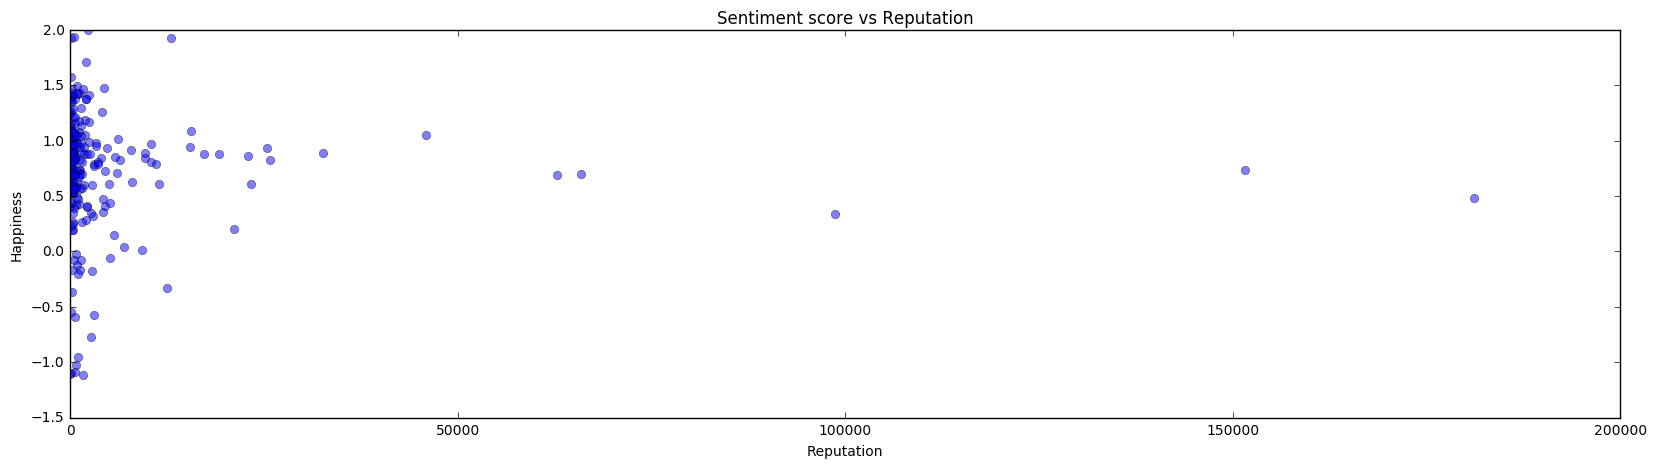

In [169]:
plt.figure(figsize=(20, 5), dpi=80)
x = rep_happy.keys()
y = rep_happy.values()
plt.plot(x, y, 'o',alpha=0.5)
#plt.xlim( 0,3500 )
plt.title('Sentiment score vs Reputation')
plt.ylabel('Happiness')
plt.xlabel('Reputation')

#### The overall results

The hypothesis that was stated in the beginning was:

1. People that code in clojure, Scala, Ruby or JavaScript are the most happy [5]
2. Caring about others and helping makes people happy (in SO it could be the people who answer most)
3. Being acknowledged, doing something meaningful (Like winning batches and reputation in SO) makes people happy
4. Money makes people happy

To answer the first hypothesis, it actually told us that asp.net makes you the most happy, or at least the people who are having tag and a twitter in Denmark is on average more happy then the other top tags based on betweenness and eigenvector centrality. Javascript is not the happiest, but is certantly not the worst off either. 
In regards to the second Hypothesis, at least on SO it does not necessarily make you more happy to answer more questions(aka helping others). However it could also say something about people who do not really have a life and use all their time on answering questions on SO.
Being aknowledged in the programming online community apparently does not affect happiness. Both of these two hypothesis are rejected, since there is not really any correlation between happiness score and anwers given/reputation. 

When looking online what programming skills that earns most money, it is stated in [15] that the ones who earn the most, here only including the ones from the list above: nr. 3 is python with an average salary of 
$104,228, then java, javascrip, C#, sql is on nr. 12 and PHP is nr. 13.  Actually it is visible that javascript, java and mysql are in the top of happiness ranking. Of course it would be very assumtious to say that it defines that money make programmers happy, but a small tendency can be seen. Of course more concrete data would need to be processed before it could be stated clearly. This goes for all the hypothesis. 


***

<h2 align="center">Discussion</h2> 



Doing a bigger project and having more of a say in what it is about was quite interesting, both in terms of all the small decisions we had to make and the coordination of getting tweets, calculating sentiment and doing the network analysis. It was challenging, but fun. There were a lot of things we wanted to add all the time, but we also had to keep the timeframe in mind. 

#### Sentiment analysis 
First of all, we should have probably worked with only english speaking countries, to ensure tweets are in English and so a lot of the trouble of getting sentiment would have been fixed. Then the function calculating function could be used for a user's entire tweet history instead of splitting up the tweets. On that note we could also simply have gone with the AFINN score and not care about the fact that the S1 wordlist had more words, and then simply use the library for both languages. However doing it the way that we did gave us a much better understanding of the idea behind sentiment analysis and the underlying diversity of the real world data.  Another element that could have been worked more on was the natural language processing with nltk. The library offers so many possibilities, but unfortunately due to time restrictions we could not play around with it a lot. A relevant observation in terms of sentiment is that even though we have a lexicon created by a danish researcher, Danish is a complex language. Not as such in the words used, but more in terms of sarcasm and irony, which is quite common; these could give false positives in terms of sentiment score. This is however a hard nut to crack, because it really depends on the mood and the combination of words. We would also assume that other countries would have a more moving sentiment than the Danish. Danish people are just never extremely happy or extremely sad in their wording. An element that we played around with but did not include was the smiley word list from AFINN; it would have been interesting to see what it would have done with the scores if it was added on top of the language sentiment. We were a bit worried about having many troubles with encoding, especially since we deal with Danish letters. Following the guidelines in [ http://nedbatchelder.com/text/unipain.html ] (see unicode sandwich) made it surprisingly painless though.  Even though we could have added more  stats, exploration and graphs , we all in all  feel that we got a good understanding of sentiment analysis, and are still up for playing around with it another time.
 

#### Network analysis

The way we approached te problem semed like a proper way and we got a lot of information out of our data. We could have made other networks and compared the different ones, but just getting the right networks that would actually give us information was harder tha expected, because the tags and users were so intertwined with the hypothesis that we wanted to investigate. But we did look at many different elements for each network that actually gave us some indication of happiness as aiming for. If we were to coninue on this project we would also have included elements from github. This would give a larger reference frame, add more details and would probarbly expand the size of the network. We looked briefly into the API of github and found it quite easy to work with. Th users on SO are most often also in Github.  A small example code of SO/Github is shown below. 

In [19]:
#Finding the github account for a test user (126014)
url = 'http://stackoverflow.com/users/126014'
data = urllib2.urlopen(url)
soup = BeautifulSoup(data, 'lxml')

for a in soup.find_all('a', href=True):
    if 'github' in a['href']:
        print "Git link found:", a['href']

Git link found: https://github.com/AutoFixture/AutoFixture
Git link found: https://github.com/ploeh


In [20]:
#retrieve the repos the user has on github
r = requests.get('https://api.github.com/users/ploeh/repos')
data=json.loads(r.content)

#get a list of the repos programming languages 
git_prog_langs = list(set(d['language'] for d in data))

Besides Github, a lot of other sites , info and communities could have been added to the project to give it a broader perspective as well as narrowing down the parameters that are important for the specific user in terms of happiness. 

#### Conclusion
Even though there could have been improvements here and there in both code, structure and choices, the project was interesting, taught us a lot and gave a small look into what the network theory and its related tools can be used for. 

***

### References


[1]Stack Overflow (2016), "About", http://stackoverflow.com/company/about , visited 12/11-2016

[2]Lyubomirsky, Sonja(2007) "The How of Happiness", positive psychology researcher (http://greatergood.berkeley.edu/topic/happiness/definition), visited 11/11-2016

[3]Joyfulldays, "What makes people happy, the top ten list" http://www.joyfuldays.com/what-makes-people-happy-the-top-10-list/ , visited 13/11-2016

[4]Bustle, What really makes a person happy",  https://www.bustle.com/articles/70762-what-really-makes-a-person-happy-9-things-science-knows-about-what-really-keeps-us-content , visited 13/11-2016

[5] IT world, "Clojure developers are the happiest developers" http://www.itworld.com/article/2693998/big-data/clojure-developers-are-the-happiest-developers.html , visited 13/11-2016

[6]StackExchange, "Sites", http://stackexchange.com/sites , visited 20/11- 2016

[7]StackEcxchange, "Help", http://data.stackexchange.com/help , visited 20/11- 2016

[8]StackExchange, "FAQ" http://data.stackexchange.com/help#faq, visted 20/11- 2016

[9] Google developers,"Python Regular Expressions" , https://developers.google.com/edu/python/regular-expressions visited 1/12-2016
[10] Spirit, "guess_language – Guess the natural language of a text", https://bitbucket.org/spirit/guess_language, visted 28/11-2016

[11]  Dodds, p. , Kameron, H. , Kloumann, I. , Bliss, C. , Danforth, C,(2011)  "Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter", http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752 visited 1/12-2016

[12]Nielsen, F. , "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

[13]Lehmann, S. (2016) http://nbviewer.jupyter.org/github/suneman/socialgraphs2016/blob/master/lectures/Week5.ipynb 

[14]Python Louvain-algorithm implementation : http://perso.crans.org/aynaud/communities/

[15]Rasmussen, "Best programming languages based on earnings and opportunities" http://www.rasmussen.edu/degrees/technology/blog/best-programming-languages-based-on-earnings-and-opportunities/ visited 7/12 2016